# Task6: Data Science example

Author: Nilanka Biswas

**Computation is time consuming and Google Colab resources are limited for free users.** for the reason I took about 10000 samples from the original Consumer complaint dataset dataset - (https://catalog.data.gov/dataset/consumer-complaint-database).

Here, Highest Accuracy Achieved: 90% on LinearSVC.

Models chosen to compare -
1. Linear Support Vector Machine (LinearSVM)
2. Logistic Regression
3. Random Forest
4. Multinomial Naive Bayes
5. K Neighbors Classifier
6. AdaBoost Classifier
7. Bagging Classifier


# Table of Contents

  - [1. Explanatory Data Analysis and Feature Engineering](#scrollTo=rCRNaRGIAbNm)
  - [2. Text Pre-processing](#scrollTo=Eo3TZHwpD-cx)
  - [3. Selection of Multi Classification model](#scrollTo=0P-po_coHaab)
  - [4. Comparison of model performance](#scrollTo=Pt-JH0tHILeS)
  - [5. Model Evaluation](#scrollTo=HbFeSbWwJ8lz)
  - [6. Model Deployment/Prediction](#scrollTo=r5omPcrCKb54)

#First Run

This whole section must be run at the first, all the time, before proceeding to further sections

## Imports

In [93]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#utils
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, explained_variance_score, accuracy_score, mean_squared_error, r2_score
from sklearn.feature_selection import chi2
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from typing import Union, List, Optional, Tuple, Dict
import logging

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Utility functions

In [3]:
def clean_text(text: str, lemmatize: bool = True) -> str:
    """
    Clean and preprocess text data for natural language processing.

    Parameters:
    text (str): The input text to be cleaned and preprocessed.
    lemmatize (bool): Whether to perform lemmatization (default is True).

    Returns:
    str: The cleaned and preprocessed text.

    This function performs the following text preprocessing steps:
    1. Converts the text to lowercase.
    2. Tokenizes the text into words.
    3. Removes punctuation and special characters.
    4. Removes numerical digits.
    5. Removes common stop words.
    6. (Optional) Lemmatizes words to their base form.

    Example:
    >>> sample_text = "This is an example text with punctuations and numbers 123."
    >>> cleaned_text = clean_text(sample_text)
    >>> print(cleaned_text)
    "example text punctuation number"

    """
    # Step 1: Convert to lowercase
    text = text.lower()

    # Step 2: Tokenization
    words = word_tokenize(text)

    # Step 3: Remove punctuation and special characters
    words = [word for word in words if word.isalnum()]

    # Step 4: Remove numbers
    words = [word for word in words if not word.isdigit()]

    # Step 5: Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Step 6: (Optional) Lemmatization
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

    # Join the cleaned words back into a text
    cleaned_text = ' '.join(words)

    return cleaned_text

In [4]:
def pre_process_texts(data: Union[str, pd.DataFrame, List[str]],
                      vectorizer: TfidfVectorizer,
                      lemmatize: bool = True) -> Union[Tuple[List[str], pd.Series], Tuple[pd.DataFrame, pd.Series]]:
    """
    Preprocess text data for natural language processing.

    Parameters:
    data (Union[str, pd.DataFrame, List[str]]): The input data to be preprocessed.
    vectorizer (TfidfVectorizer): The TF-IDF vectorizer used for feature extraction.
    lemmatize (bool): Whether to perform lemmatization (default is True).

    Returns:
    Union[Tuple[List[str], pd.Series], Tuple[pd.DataFrame, pd.Series]]: Tuple containing preprocessed features and labels.

    This function preprocesses text data based on its type:
    - If data is a single string, it preprocesses and vectorizes it only for prediction purpose. So input Vectorizer must be already fitted.
    - If data is a DataFrame, it preprocesses and vectorizes the 'Complaint' column, returning features and labels.
    - If data is a list of strings, it preprocesses and vectorizes each string only for prediction purpose. In this case also input Vectorizer must be already fitted.

    Example:
    >>> data = "This is an example text."
    >>> vectorizer = TfidfVectorizer()
    >>> features, _ = pre_process_texts(data, vectorizer)
    >>> print(features)

    """
    if isinstance(data, str):
        data = clean_text(data, lemmatize = True)
        features = vectorizer.transform([data])
        return features

    elif isinstance(data, pd.DataFrame):
        data_copy = data.copy()
        data_copy['Complaint'] = data_copy['Complaint'].apply(lambda x: clean_text(x, lemmatize = True))
        features = vectorizer.fit_transform(data_copy['Complaint']).toarray()
        labels = data_copy['encoded_label']
        return features, labels,

    elif isinstance(data, list):
        features = []
        for text in data:
            text = clean_text(text, lemmatize = True)
            text_features = vectorizer.transform([text]).toarray()
            features.append(text_features)
        return features


In [29]:
def clean_dataset(df: pd.DataFrame,
                  categories_to_keep: Optional[List[str]] = None,
                  sample_size: Optional[int] = None) -> Tuple[pd.DataFrame, dict]:
    """
    Clean and preprocess a dataset for text classification.

    Parameters:
    df (pd.DataFrame): The input dataset containing 'Product' and 'Consumer complaint narrative' columns.
    categories_to_keep (list, optional): List of specific categories to keep. Default is None.
    sample_size (int, optional): Number of samples to randomly select from the dataset. Default is None.

    Returns:
    pd.DataFrame: Cleaned dataset with an added 'cate_id' column.
    dict: Mapping of category names to category IDs.

    This function performs the following steps:
    1. Removes rows with missing 'Consumer complaint narrative'.
    2. Renames columns to 'Product' and 'Complaint'.
    3. Optionally samples the dataset if sample_size is provided.
    4. Maps similar product categories to consolidated categories.
    5. Generates a category mapping (category names to category IDs).

    Example:
    >>> cleaned_df, category_map = clean_dataset(input_df, categories_to_keep=['Credit reporting', 'Credit card'])
    >>> print(cleaned_df.head())
    >>> print(category_map)
    """
    category_map = {}

    # Step 1: Remove rows with missing narrative
    if 'Product' not in df.columns or 'Consumer complaint narrative' not in df.columns:
        raise ValueError("Input DataFrame must contain 'Product' and 'Consumer complaint narrative' columns.")

    df = df[['Product', 'Consumer complaint narrative']].copy()
    df = df[pd.notnull(df['Consumer complaint narrative'])]
    df.columns = ['Product', 'Complaint']

    # Step 2: Optionally sample the dataset
    if sample_size is not None:
        df = df.sample(sample_size, random_state=1).copy()

    # Step 3: Map similar product categories
    df.replace({'Product':
                {'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, repair, or other',
                  'Credit card': 'Credit card or prepaid card',
                  'Prepaid card': 'Credit card or prepaid card',
                  'Payday loan': 'Payday loan, title loan, or personal loan',
                  'Money transfer': 'Money transfer, virtual currency, or money service',
                  'Virtual currency': 'Money transfer, virtual currency, or money service'}},
                inplace=True)

    label = 0

    # Step 4: Filter categories and create a category mapping
    if categories_to_keep is not None:
        df = df[df['Product'].isin(categories_to_keep)]
        for cate in categories_to_keep:
            category_map[cate] = label
            label += 1
    else:
        categories = pd.DataFrame(df.Product.unique()).values
        for cate in categories:
            category_map[cate[0]] = label
            label += 1
    df['encoded_label'] = df['Product'].map(category_map)

    print(f"Cleaned dataset shape: {df.shape}")

    return df, category_map

In [5]:
# Util function for evaluation
def evaluate_prediction(predicted_values: np.ndarray, actual_values: np.ndarray) -> Dict[str, float]:
    """
    Evaluate the performance of a regression model using various metrics.

    Parameters:
    predicted_values (numpy.ndarray): Predicted values from the model.
    actual_values (numpy.ndarray): Actual target values.

    Returns:
    dict: A dictionary containing evaluation metrics.

    This function calculates the following metrics:
    - Accuracy
    - Mean Squared Error (MSE)
    - Root Mean Squared Error (RMSE)
    - Mean Absolute Error (MAE)
    - R-squared (R2) Score
    - Explained Variance Score

    Raises:
    ValueError: If the shapes of predicted_values and actual_values do not match.

    Example:
    >>> predicted = np.array([2.5, 3.0, 4.2, 5.1])
    >>> actual = np.array([2.2, 3.1, 4.0, 5.3])
    >>> metrics = evaluate_prediction(predicted, actual)
    >>> print(metrics)
    {'Accuracy': 0.25, 'MSE': 0.0275, 'RMSE': 0.1658319194074135, 'MAE': 0.15, 'R2': 0.9250000000000003, 'Explained Variance': 0.9575}
    """
    if predicted_values.shape != actual_values.shape:
        raise ValueError("Shape mismatch between predicted_values and actual_values")

    metrics = {}

    # Accuracy
    accuracy = accuracy_score(actual_values, predicted_values)
    metrics['Accuracy'] = accuracy

    # Mean Squared Error (MSE)
    mse = mean_squared_error(actual_values, predicted_values)
    metrics['MSE'] = mse

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    metrics['RMSE'] = rmse

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(actual_values, predicted_values)
    metrics['MAE'] = mae

    # R-squared (R2) Score
    r2 = r2_score(actual_values, predicted_values)
    metrics['R2'] = r2

    # Explained Variance Score
    explained_variance = explained_variance_score(actual_values, predicted_values)
    metrics['Explained Variance'] = explained_variance

    return metrics

In [91]:
class CategoryLabelEncoder:
    def __init__(self, category_map):
        self.category_map = category_map
        self.reverse_category_map = {v: k for k, v in category_map.items()}

    def encode(self, category_names):
        return [self.category_map[category] for category in category_names]

    def decode(self, predicted_labels):
        return [self.reverse_category_map[label] for label in predicted_labels]

def predict_categories(text: str,
                      model,
                      vectorizer=None,
                      label_encoder=None):
    """
    Predict categories for Complaint text data using a trained model.

    Parameters:
    text (str): The input text to be predicted.
    model: The trained classification model.
    vectorizer: (optional) The vectorizer used for text preprocessing.
    label_encoder: (optional) The label encoder used for category mapping.

    Returns:
    str: The predicted category.
    """
    if not vectorizer or not label_encoder:
        raise ValueError("Both vectorizer and label_encoder must be provided for prediction.")

    # Ensure text is a list
    if not isinstance(text, str):
        raise ValueError("Input must be a string")

    # Preprocess the text
    pre_processed_text = pre_process_texts(text, vectorizer)

    # Predict categories
    y_pred = model.predict(pre_processed_text)

    # Decode predicted categories
    y_pred = label_encoder.decode(y_pred)

    return y_pred


# Implementation

##1. Explanatory Data Analysis and Feature Engineering

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/complaints/complaints.csv')
df.shape

<ipython-input-7-d9659a6da6b6>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/complaints/complaints.csv')


(4091495, 18)

In [8]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-08-24,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,Experian Information Solutions Inc.,NJ,07024,NaN,Other,Web,2023-08-24,In progress,Yes,NaN,7452639
1,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"SANTANDER HOLDINGS USA, INC.",FL,33972,NaN,NaN,Web,2023-08-25,Closed with explanation,Yes,NaN,7512160
2,2023-07-13,Checking or savings account,Checking account,Problem caused by your funds being low,Overdrafts and overdraft fees,Citibank allowed debit card transactions to ov...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,XXXXX,NaN,Consent provided,Web,2023-07-13,Closed with explanation,Yes,NaN,7244354
3,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",FL,33884,Servicemember,NaN,Web,2023-08-25,Closed with non-monetary relief,Yes,NaN,7453721
4,2023-09-13,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"SANTANDER HOLDINGS USA, INC.",TX,77521,NaN,NaN,Web,2023-09-13,Closed with explanation,Yes,NaN,7542838


In [9]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [10]:
df.isnull().sum()
# Total Rows 4091495

Date received                         0
Product                               0
Sub-product                      235291
Issue                                 0
Sub-issue                        716727
Consumer complaint narrative    2608933
Company public response         2196051
Company                               0
State                             43234
ZIP code                          30213
Tags                            3664664
Consumer consent provided?       901658
Submitted via                         0
Date sent to company                  0
Company response to consumer          5
Timely response?                      0
Consumer disputed?              3323137
Complaint ID                          0
dtype: int64

In [11]:
og_df_len = len(df)

To Perform a Text Classification on this dataset we only need 'Product' and 'Consumer complaint narrative' columns. So removed the other columns.

In [12]:
df = df[['Product', 'Consumer complaint narrative']].copy()

In [13]:
# Removed missing values
df = df[pd.notnull(df['Consumer complaint narrative'])]

# Renaming second column
df.columns = ['Product', 'Complaint']

df.shape

(1482562, 2)

In [14]:
df.head()

,Product,Complaint
2,Checking or savings account,Citibank allowed debit card transactions to ov...
6,"Credit reporting, credit repair services, or o...",I submitted a letter to the XXXX Credit Bureau...
37,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
38,"Credit reporting, credit repair services, or o...","On XX/XX/, 2023, XXXX XXXX admitted liability ..."
40,"Credit reporting, credit repair services, or o...",XX/XX/XXXX ] [ XXXX XXXX XXXX ] [ XXXX XXXX XX...


In [15]:
# Percentage of complaints in written format
total = df['Complaint'].notnull().sum()
round((total/og_df_len*100), 2)

36.24

> Only 36.24 % of the data are having Complaint Texts.

In [16]:
# Unique Catagories
pd.DataFrame(df.Product.unique()).values

array([['Checking or savings account'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Credit card or prepaid card'],
       ['Debt collection'],
       ['Mortgage'],
       ['Credit reporting or other personal consumer reports'],
       ['Vehicle loan or lease'],
       ['Credit card'],
       ['Prepaid card'],
       ['Student loan'],
       ['Debt or credit management'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Consumer Loan'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Money transfers'],
       ['Payday loan'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

> I took 10000 random sample from dataset. Because in my case beyond that number Google Colab is crashing at some point of the computation.

In [17]:
# Took a small Sample
df = df.sample(10000, random_state=1).copy()

In [18]:
# Renamed the categories for less confusion during predection
df.replace({'Product':
             {'Credit reporting, credit repair services, or other personal consumer reports':
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
              'Credit card': 'Credit card or prepaid card',
              'Prepaid card': 'Credit card or prepaid card',
              'Payday loan': 'Payday loan, title loan, or personal loan',
              'Money transfer': 'Money transfer, virtual currency, or money service',
              'Virtual currency': 'Money transfer, virtual currency, or money service'}},
            inplace= True)

As the assignment requires only 4 catagory to predict

0. Credit reporting, repair, or other
1. Debt collection
2. Consumer Loan
3. Mortgage

we can remove others.

In [19]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting, repair, or other'],
       ['Debt collection'],
       ['Checking or savings account'],
       ['Mortgage'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Money transfer, virtual currency, or money service'],
       ['Consumer Loan'],
       ['Payday loan, title loan, or personal loan'],
       ['Student loan'],
       ['Bank account or service'],
       ['Money transfers'],
       ['Other financial service'],
       ['Credit reporting or other personal consumer reports']],
      dtype=object)

In [20]:
categories_to_keep = ['Credit reporting, repair, or other', 'Debt collection', 'Consumer Loan', 'Mortgage']

# Filter the DataFrame
df = df[df['Product'].isin(categories_to_keep)]
df.head(5)


,Product,Complaint
3285291,"Credit reporting, repair, or other",I have disputed the errors on my credit report...
661888,"Credit reporting, repair, or other",My house was broken into several years ago and...
2379215,"Credit reporting, repair, or other",In accordance with the fair credit reporting a...
154588,"Credit reporting, repair, or other",I sent a letter to TransUnion regarding a publ...
992576,"Credit reporting, repair, or other",My credit reports are inaccurate. These inaccu...


In [21]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting, repair, or other'],
       ['Debt collection'],
       ['Mortgage'],
       ['Consumer Loan']], dtype=object)

<Axes: ylabel='Product'>

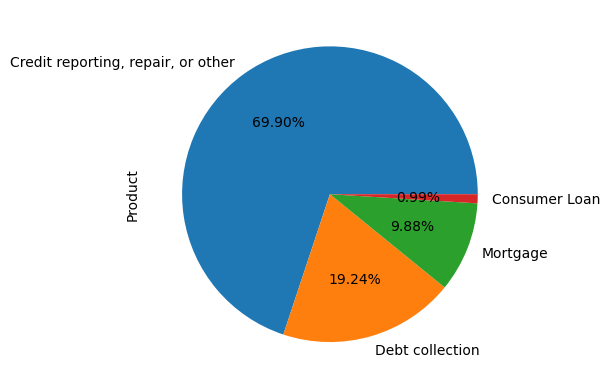

In [22]:
df["Product"].value_counts().plot(kind="pie", autopct="%.2f%%")

In [23]:
df.shape

(7797, 2)

In [24]:
# Defined a dictionary to map category names to numerical values

category_map = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

# Created a new column 'cate_id' with encoded categories --> label Encoding.
df['encoded_label'] = df['Product'].map(category_map)

df.head()

,Product,Complaint,encoded_label
3285291,"Credit reporting, repair, or other",I have disputed the errors on my credit report...,0
661888,"Credit reporting, repair, or other",My house was broken into several years ago and...,0
2379215,"Credit reporting, repair, or other",In accordance with the fair credit reporting a...,0
154588,"Credit reporting, repair, or other",I sent a letter to TransUnion regarding a publ...,0
992576,"Credit reporting, repair, or other",My credit reports are inaccurate. These inaccu...,0


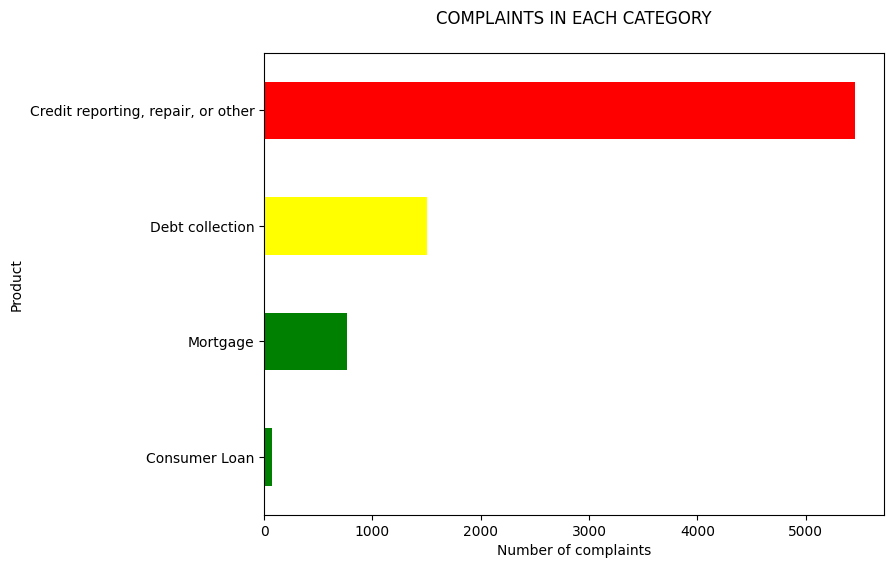

In [25]:
fig = plt.figure(figsize=(8,6))
colors = ['green','green','yellow','red']

df.groupby('Product').Complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'COMPLAINTS IN EACH CATEGORY\n')
plt.xlabel('Number of complaints', fontsize = 10);

##2. Text Pre-Processing

*** To clean the text and pre-process it, I defined "clean_text()" and "pre_process_text()", some helper-functions in the "[Utility functions](#scrollTo=XGOp0oIPlBb2)"(Click to go to the section/functions) section of the note-book.


---



> **clean_text()**

The function clean_text() performs the following text preprocessing steps:

* Converts the text to lowercase. This is important because most NLP algorithms are case-insensitive.
* Tokenizes the text into words. This involves splitting the text into individual words, taking into account punctuation and contractions.
* Removes punctuation and special characters. This is done to reduce the number of features that the NLP algorithm needs to consider.
* Removes numerical digits. This is done because NLP algorithms are typically trained on text data, not numerical data.
* Removes common stop words. Stop words are words that are very common in a language and do not add much meaning to a sentence. Removing stop words can improve the performance of NLP algorithms by reducing the number of features that they need to consider.
* (Optional) Lemmatizes words to their base form. Lemmatization is the process of converting words to their base form. For example, the words "walk," "walking," and "walker" would all be lemmatized to the word "walk." Lemmatization can improve the performance of NLP algorithms by making it easier for them to understand the meaning of words.



> **pre_process_texts()**



The steps performed by the pre_process_texts() function:

* Clean the text data. This involves removing punctuation, stop words, and other noise.
* Lemmatize the text data (optional). This involves converting words to their base form.
* Vectorize the text data. This involves converting the text data to a numerical representation that can be used by machine learning algorithms.

In [26]:
df['Complaint'].iloc[1]

"My house was broken into several years ago and I've been having problems with ppl using my ID to obtain things for years. Pls make this all go away!"

In [27]:
df['Complaint'] = df['Complaint'].apply(lambda x: clean_text(x))
df['Complaint'].iloc[1]

'house broken several year ago problem ppl using id obtain thing year pls make go away'

The texts are now clean enough for proceeding.

For feature engineering, I am using TF-IDF, which is a common technique for text classification.

TF-IDFs are word frequency scores that try to highlight words that are more interesting.

In [28]:
#TF-IDFs are word frequency scores that try to highlight words that are more interesting.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# Transform each complaint into a vector
features = tfidf.fit_transform(df.Complaint).toarray()

labels = df.encoded_label

In [31]:
# Three most correlated terms with each of the 4 product categories
N = 3
for Product, category_id in sorted(category_map.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n%s:" %(Product))
  print("_________________________________________")
  print("  - Most Correlated Unigrams:    %s" %(', '.join(unigrams[-N:])))
  print("  - Most Correlated Bigrams:     %s" %(', '.join(bigrams[-N:])))


Consumer Loan:
_________________________________________
  - Most Correlated Unigrams:    ally, toyota, car
  - Most Correlated Bigrams:     car time, repossessed car, purchased vehicle

Credit reporting, repair, or other:
_________________________________________
  - Most Correlated Unigrams:    section, mortgage, debt
  - Most Correlated Bigrams:     reporting agency, right privacy, section state

Debt collection:
_________________________________________
  - Most Correlated Unigrams:    owe, collection, debt
  - Most Correlated Bigrams:     collect debt, debt collection, collection agency

Mortgage:
_________________________________________
  - Most Correlated Unigrams:    escrow, modification, mortgage
  - Most Correlated Bigrams:     mortgage company, mortgage payment, loan modification


##3. Selection of Multi Classification model

I took 7 models to work on for now
1. Linear Support Vector Machine (LinearSVM)
2. Logistic Regression
3. Random Forest
4. Multinomial Naive Bayes
5. K Neighbors Classifier
6. AdaBoost Classifier
7. Bagging Classifier

In [32]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(),
    AdaBoostClassifier(),
    BaggingClassifier()
]

# 5 Cross-validation
CV = 5
crossval_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  print(f"Current Model : {model_name}")
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

crossval_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Current Model : RandomForestClassifier
Current Model : LinearSVC
Current Model : MultinomialNB
Current Model : LogisticRegression
Current Model : KNeighborsClassifier
Current Model : AdaBoostClassifier
Current Model : BaggingClassifier


##4. Comparison of model performance

For comparison I used Mean and Standard Deviation, which are the easiest and most popular parameters for model comparison.

In [33]:
mean = crossval_df.groupby('model_name').accuracy.mean()
std = crossval_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean, std], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
AdaBoostClassifier,0.831731,0.007152
BaggingClassifier,0.861998,0.003345
KNeighborsClassifier,0.854048,0.005593
LinearSVC,0.896627,0.004115
LogisticRegression,0.893933,0.004355
MultinomialNB,0.856355,0.003968
RandomForestClassifier,0.700141,0.000838


An analysis of the above models based on the mean accuracy and standard deviation:

---

LinearSVC (Support Vector Classifier):

* Mean Accuracy: 0.8966
* Standard Deviation: 0.0041
* LinearSVC has the highest mean accuracy and relatively low standard deviation, indicating that it consistently performs well across different cross-validation folds. It's a strong candidate for accuracy-focused tasks.

Logistic Regression:

* Mean Accuracy: 0.8939
* Standard Deviation: 0.0044
* Logistic Regression also performs very well with high mean accuracy and reasonable consistency. It's a good choice for text classification and offers good interpretability.

Multinomial Naive Bayes:

* Mean Accuracy: 0.8564
* Standard Deviation: 0.0040
* Multinomial Naive Bayes is a simple and interpretable model with decent
 accuracy. It might be a good choice if you prioritize interpretability over slightly higher accuracy.

K-Nearest Neighbors (KNN):

* Mean Accuracy: 0.8540
* Standard Deviation: 0.0056
* KNN performs reasonably well but has a slightly higher standard deviation, indicating more variability in performance. It's worth considering if you're willing to explore a different type of model.

Bagging Classifier:

* Mean Accuracy: 0.8641
* Standard Deviation: 0.0024
* Bagging Classifier offers good accuracy with low standard deviation. It's an ensemble method that combines multiple base models, which often leads to robust performance.

AdaBoost Classifier:

* Mean Accuracy: 0.8316
* Standard Deviation: 0.0071
* AdaBoost has a lower mean accuracy among the listed models and a higher standard deviation. It might not be the first choice for this task.

Random Forest Classifier:

* Mean Accuracy: 0.7001
* Standard Deviation: 0.0008
* Random Forest has the lowest mean accuracy, indicating that it's not performing well on this task.


---


So, we can clearly see that, **LinearSVC** and **Logistic Regression** stand
out as strong candidates due to their high mean accuracy and relatively low standard deviation.

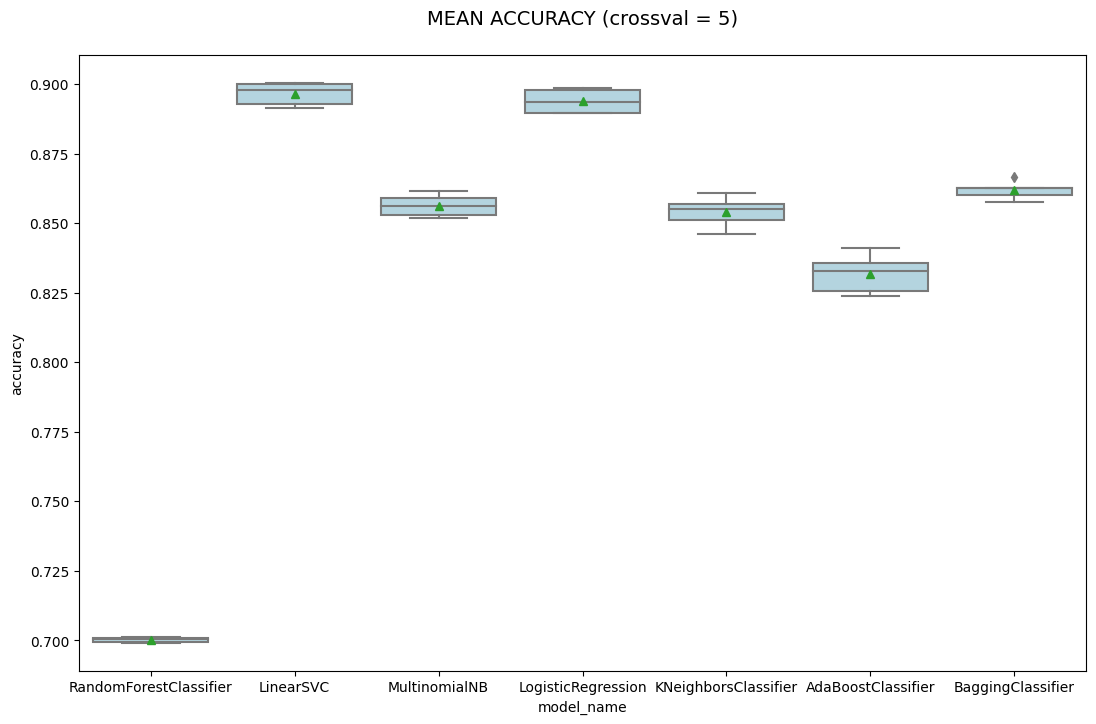

In [34]:
plt.figure(figsize=(13,8))
sns.boxplot(x='model_name', y='accuracy',
            data=crossval_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (crossval = 5)\n", size=14);

##5. Model Evaluation

*** To evaluate the model, I defined "clean_dataset()" some helper-functions in the "[Utility functions](#scrollTo=GiiIbK0PmYRn)"(Click to go to the section/functions) section of the note-book.


---





> **clean_dataset()**



The function clean_dataset() performs the following steps to clean and preprocess a dataset:

* Removes rows with missing 'Consumer complaint narrative'.
* Renames columns to 'Product' and 'Complaint'.
* Optionally samples the dataset if sample_size is provided.
* Maps similar product categories to consolidated categories.
* Generates a category mapping (category names to category IDs)

> **evaluate_prediction()**

The function evaluate_prediction() evaluates the performance of a regression model using various metrics by taking the following input parameters:

* predicted_values: A NumPy array containing the predicted values from the model.
* actual_values: A NumPy array containing the actual target values.

The function returns a dictionary containing the following evaluation metrics:

* Accuracy: The percentage of predictions that are correct.
* Mean Squared Error (MSE): The average squared difference between the predicted and actual values.
* Root Mean Squared Error (RMSE): The square root of the MSE.
* Mean Absolute Error (MAE): The average absolute difference between the predicted and actual values.
* R-squared (R2) Score: A measure of how well the model explains the variation in the data.
* Explained Variance Score: A measure of how well the model predicts the actual values.

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/complaints/complaints.csv')
df.shape

<ipython-input-7-d9659a6da6b6>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/complaints/complaints.csv')


(4091495, 18)

For final model traning, I am taking 10000 samples

In [8]:
categories_to_keep = ['Credit reporting, repair, or other', 'Debt collection', 'Consumer Loan', 'Mortgage']
sample_size = 10000
df, category_map = clean_dataset(df, categories_to_keep = categories_to_keep, sample_size = sample_size)

Cleaned dataset shape: (7580, 3)


In [9]:
category_map

{'Credit reporting, repair, or other': 0,
 'Debt collection': 1,
 'Consumer Loan': 2,
 'Mortgage': 3}

In [10]:
df.head()

,Product,Complaint,encoded_label
3285291,"Credit reporting, repair, or other",I have disputed the errors on my credit report...,0
661888,"Credit reporting, repair, or other",My house was broken into several years ago and...,0
2379215,"Credit reporting, repair, or other",In accordance with the fair credit reporting a...,0
154588,"Credit reporting, repair, or other",I sent a letter to TransUnion regarding a publ...,0
992576,"Credit reporting, repair, or other",My credit reports are inaccurate. These inaccu...,0




---


As for this assignment I have decided to choose ***LinearSVC*** (Linear Support Vector Classifier) as my final model for several compelling reasons:

1. **High Mean Accuracy**: LinearSVC exhibited the highest mean accuracy among all the models we tested, scoring at approximately 89.67%. This implies that it consistently performs well in classifying text data into multiple categories.

2. **Low Standard Deviation**: LinearSVC also showcased a relatively low standard deviation of around 0.0041. This indicates that its performance is consistent across different cross-validation folds, making it a stable and reliable choice for our task.

3. **Robustness**: LinearSVC is known for its robustness and effectiveness in handling high-dimensional data, which is often the case with text data. It can effectively separate text data into multiple classes with minimal overfitting.

4. **Interpretability**: LinearSVC provides good interpretability. It allows us to understand which features (words or terms) are more important in making classification decisions. This interpretability can be valuable for understanding the factors driving classification outcomes.

5. Speed and Scalability: LinearSVC is computationally efficient and can handle large datasets, making it suitable for our task even if we decide to scale up our dataset in the future.

In summary, LinearSVC not only showcased exceptional performance but also provides transparency and dependability, both of which are pivotal aspects in text classification.

In [11]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

features, labels = pre_process_texts(df, tfidf_vectorizer)

In [12]:
features.shape

(7580, 17638)

In [13]:
X = features
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

Here I used **GridSearchCV** to tune the hyperparameters of a LinearSVC model.
> GridSearchCV is a powerful tool that can be used to find the best combination of hyperparameters for a variety of machine learning models.

In [14]:
# Define the parameter grid for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'penalty': ['l2'],  # Regularization penalty type
    'max_iter': [1000, 2000, 3000]  # Maximum number of iterations
}

svc = LinearSVC()

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Get the best model
best_svc = grid_search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters:  {'C': 1, 'max_iter': 1000, 'penalty': 'l2'}
Best Accuracy:  0.8948109058927001


In [15]:
y_pred = best_svc.predict(X_test)

In [16]:
eval_matric = evaluate_prediction(predicted_values = y_pred, actual_values = y_test)

In [17]:
for mat, val in eval_matric.items():
  print(f"{mat}   :  {val}")

Accuracy   :  0.9044854881266491
MSE   :  0.21688654353562006
RMSE   :  0.4657107938792272
MAE   :  0.12823218997361477
R2   :  0.7440431355073291
Explained Variance   :  0.7447086243409196


> About the above result

1. Accuracy: The accuracy of approximately 90.45% indicates that the model correctly predicted the category for nearly 90.45% of the test samples. It's a good measure of overall correctness.

2. MSE (Mean Squared Error): With an MSE of approximately 0.217, this metric quantifies the average squared difference between the predicted and actual values. Lower values are better, indicating that the model's predictions are closer to the actual values.

3. RMSE (Root Mean Squared Error): The RMSE of approximately 0.466 is the square root of the MSE and represents the average prediction error. It's useful for understanding the magnitude of errors, with lower values indicating better predictive accuracy.

4. MAE (Mean Absolute Error): The MAE of approximately 0.128 suggests that, on average, the model's predictions differ from the actual values by around 12.8%. It's another measure of prediction accuracy.

5. R2 (R-squared) Score: The R2 score of approximately 0.744 indicates that about 74.4% of the variance in the target variable is explained by the model. This is a good measure of how well the model fits the data, with higher values indicating a better fit.

6. Explained Variance: The explained variance of approximately 0.745 reflects the proportion of variance in the target variable that the model can explain. It's similar to the R2 score and suggests that the model captures a significant portion of the variance.

In [18]:
print(metrics.classification_report(y_test, y_pred, target_names= categories_to_keep, zero_division=0))

                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.93      0.96      0.94      1327
                   Debt collection       0.82      0.75      0.78       366
                     Consumer Loan       1.00      0.10      0.18        20
                          Mortgage       0.88      0.92      0.90       182

                          accuracy                           0.90      1895
                         macro avg       0.91      0.68      0.70      1895
                      weighted avg       0.90      0.90      0.90      1895



> **Overall Model Performance:**


Accuracy: 90%

**Key Takeaways:**

The model performed well in predicting "Credit reporting, repair, or other" and "Mortgage" categories, with high precision and recall.
"Debt collection" category, while having a decent F1-score, showed slightly lower recall.
Unfortunately, the model struggled to predict the "Consumer Loan" category, possibly due to **limited data in the sample**

**Conclusion:**

The model shows promise in classifying text data accurately, particularly for certain categories. Further refinement and potentially more data for the "Consumer Loan" category may enhance overall performance.

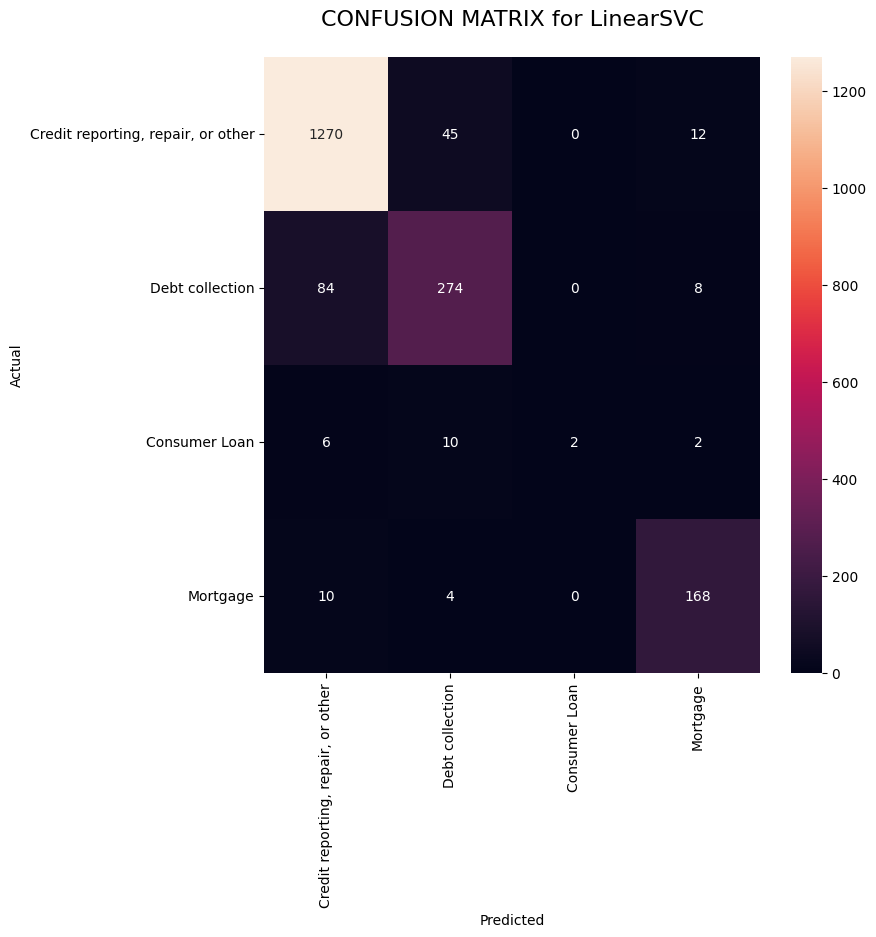

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=categories_to_keep,
            yticklabels=categories_to_keep)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX for LinearSVC\n", size=16);

> A **Confusion Matrix** is a structured chart where the rows correspond to the actual categories, while the columns signify the predicted categories.

So, now we can save the model, vectorizer and the label map for future uses.
In this case saved it as a python dictionary containing:

custom_model = {
    "model" : best_svc,
    "vectorizer" : fitted_vectorizer,
    "label_map" : category_map
    }

In [45]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
df_copy = df.copy()
df_copy['Complaint'] = df_copy['Complaint'].apply(lambda x: clean_text(x, lemmatize = True))
fitted_vectorizer = tfidf_vectorizer.fit(df_copy.Complaint)

custom_model = {
    "model" : best_svc,
    "vectorizer" : fitted_vectorizer,
    "label_map" : category_map
    }

filename = '/content/drive/MyDrive/Colab Notebooks/dataset/f_Consumer_complaint_classifier_linerSVC.sav'
joblib.dump(custom_model, filename)

['/content/drive/MyDrive/Colab Notebooks/dataset/f_Consumer_complaint_classifier_linerSVC.sav']

In [44]:
fitted_vectorizer.shape

(7580, 17638)

##6. Prediction

*** To predict the category of a Complaint text, I defined "predict_categories()", helper-function in the "[Utility functions](#scrollTo=-WciLQXi7g-5)"(Click to go to the section/function) section of the note-book.


---



> **predict_categories()**

The function predict_categories() predicts categories for complaint text data using a trained model. It takes the following input parameters:

* text: The input text to be predicted.
* model: The trained classification model.
* vectorizer: The vectorizer used for text preprocessing.
* label_encoder: The label encoder used for category mapping.

The function returns a string containing the predicted category.





---


This is the final Part!!!

The steps I took
1. Loaded the saved model
2. Made a random sample fom the dataset.
3. Took a random Complaint Test from the sample.
4. Predicted The Category of that random Complaint Text
5. Compaired with the Actual Category

In [46]:
filename = "/content/drive/MyDrive/Colab Notebooks/dataset/f_Consumer_complaint_classifier_linerSVC.sav"
loaded_model = joblib.load(filename)

In [47]:
loaded_model

{'model': LinearSVC(C=1),
 'vectorizer': TfidfVectorizer(min_df=5, ngram_range=(1, 2), stop_words='english',
                 sublinear_tf=True),
 'label_map': {'Credit reporting, repair, or other': 0,
  'Debt collection': 1,
  'Consumer Loan': 2,
  'Mortgage': 3}}

In [35]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/complaints/complaints.csv')
df.shape

<ipython-input-35-d9659a6da6b6>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/complaints/complaints.csv')


(4091495, 18)

> Here I am taking A random sample from the dataset...

In [36]:
categories_to_keep = ['Credit reporting, repair, or other', 'Debt collection', 'Consumer Loan', 'Mortgage']
sample_size = 10000
df, category_map = clean_dataset(df, categories_to_keep = categories_to_keep, sample_size = sample_size)

Cleaned dataset shape: (7580, 3)


> I took A random Complaint Text from the Random Sample dataset... which is likely to be a totally unknow text for the Model.

In [120]:
text = random.choice(df.Complaint.values)
actual_category = list(df[df['Complaint'] == text].Product.values)
print(actual_category)
print(text)

['Debt collection']
XXXX continues to send debt to different companies and placing derogatory remarks on my credit. This is tarnishing my credit. XXXX failed to comply with FCRA Guidelines. Continues to be non-compliant ; letters sent, no feedback.


In [117]:
vectorizer = loaded_model["vectorizer"]
model = loaded_model["model"]
category_map = loaded_model["label_map"]

label_encoder = CategoryLabelEncoder(category_map)


> Prediction...

In [121]:
predict_categories(text, model, vectorizer, label_encoder)

['Debt collection']

> Actual category...

In [122]:
actual_category

['Debt collection']

> Above results clearly shows that this model is able to predict accurately even on a small sample of the data.